In [2]:
!pip install opencv-python
!pip uninstall opencv-python-headless

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/38/d2/3e8c13ffc37ca5ebc6f382b242b44acb43eb489042e1728407ac3904e72f/opencv_python-4.8.1.78-cp37-abi3-win_amd64.whl.metadata
  Using cached opencv_python-4.8.1.78-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.8.1.78-cp37-abi3-win_amd64.whl (38.1 MB)


In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [5]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


In [150]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\Admins\.labelmerc


In [13]:
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

In [99]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [100]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
images = tf.data.Dataset.list_files('data\\train\\images\\*.jpg', shuffle = True)

In [17]:
images.as_numpy_iterator().next()

b'data\\train\\images\\72518699-720d-11ee-b5ed-fb167ef1e36f.jpg'

In [18]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [19]:
images = images.map(load_image)

In [20]:
images.as_numpy_iterator().next()

array([[[162, 171, 180],
        [162, 171, 180],
        [163, 172, 181],
        ...,
        [156, 153, 148],
        [156, 153, 148],
        [156, 153, 148]],

       [[161, 170, 179],
        [162, 171, 180],
        [163, 172, 181],
        ...,
        [155, 152, 147],
        [156, 153, 148],
        [156, 153, 148]],

       [[163, 170, 178],
        [163, 170, 178],
        [164, 171, 179],
        ...,
        [153, 152, 148],
        [156, 152, 149],
        [156, 152, 149]],

       ...,

       [[124, 124, 134],
        [124, 127, 136],
        [128, 128, 138],
        ...,
        [ 39,  33,  37],
        [ 41,  32,  37],
        [ 42,  33,  38]],

       [[123, 125, 137],
        [123, 127, 138],
        [127, 129, 141],
        ...,
        [ 37,  31,  35],
        [ 39,  30,  33],
        [ 40,  31,  34]],

       [[123, 127, 138],
        [122, 126, 137],
        [126, 130, 141],
        ...,
        [ 36,  30,  34],
        [ 38,  29,  32],
        [ 39,  30,  33]]

# Raw Image Data Visualization

In [21]:
image_generator = images.batch(4).as_numpy_iterator()

In [22]:
plot_images = image_generator.next()

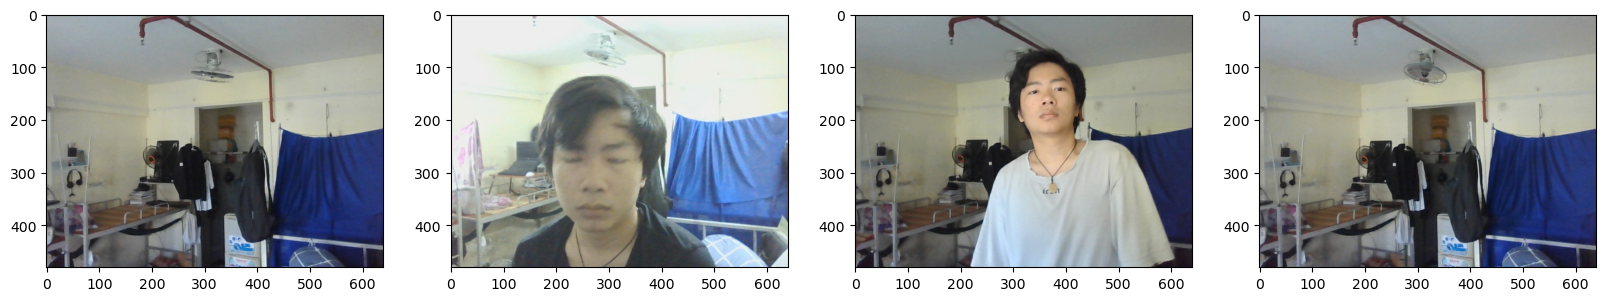

In [23]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
    
plt.show() 

# Split the dataset (Manually)

In [15]:
120 *.7 #84 train

84.0

In [16]:
120 * .15 # 18 for val, 18 for test

18.0

In [98]:
for folder in ['train', 'val', 'test']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split(".")[0] + '.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

# Data Augmentation

In [75]:
import albumentations as alb

In [76]:
augmentor = alb.Compose([
    alb.RandomCrop(width = 450, height = 450),
    alb.HorizontalFlip(p = 0.5),
    alb.RandomBrightnessContrast(p = 0.2),
    alb.RGBShift(p = 0.2),
    alb.VerticalFlip(p = 0.5)],
    bbox_params = alb.BboxParams(format = 'albumentations', 
                                 label_fields = ['class_labels']))

In [24]:
img = cv2.imread(os.path.join('data', 'train', 'images', '60471e21-7098-11ee-860d-bfe26fb992fa.jpg'))

In [25]:
with open(os.path.join('data', 'train', 'labels', '60471e21-7098-11ee-860d-bfe26fb992fa.json'), 'r') as f:
    label = json.load(f)

In [30]:
label['shapes'][0]['points']

[[145.78125, 70.98958333333331], [445.78125000000006, 407.96875]]

In [31]:
coords = [0, 0, 0, 0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [32]:
coords

[145.78125, 70.98958333333331, 445.78125000000006, 407.96875]

In [33]:
coords = list(np.divide(coords, [640, 480, 640, 480]))

In [34]:
coords

[0.227783203125, 0.14789496527777773, 0.6965332031250001, 0.8499348958333334]

# Apply augmentation

In [35]:
augmented = augmentor(image = img,
                     bboxes = [coords],
                     class_labels = ['face'])

In [38]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [41]:
augmented['bboxes']

[(0.09826388888888882,
  0.14673611111111107,
  0.7649305555555556,
  0.8955787037037037)]

In [42]:
print(augmented['bboxes'][0][:2])
print(augmented['bboxes'][0][2:])

(0.09826388888888882, 0.14673611111111107)
(0.7649305555555556, 0.8955787037037037)


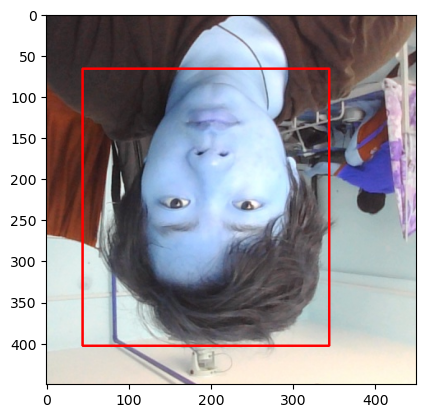

In [44]:
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
             tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
             (255, 0, 0), 2)
plt.imshow(augmented['image'])

# Build And Run Augmentation Pipeline

In [77]:
for partition in ['']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            # For each image, create 60 different version of it
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', 'train', 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', 'train', 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [51]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            # For each image, create 60 different version of it
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [24]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [25]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [26]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [27]:
train_images.as_numpy_iterator().next()

array([[[0.67696077, 0.66629905, 0.7324142 ],
        [0.6768382 , 0.672549  , 0.7207721 ],
        [0.6745098 , 0.6696078 , 0.7112745 ],
        ...,
        [0.78137255, 0.79362744, 0.8745098 ],
        [0.7864583 , 0.79001224, 0.8819853 ],
        [0.7730392 , 0.7857843 , 0.8808824 ]],

       [[0.66862744, 0.66862744, 0.71568626],
        [0.6784314 , 0.6784314 , 0.7176471 ],
        [0.6740809 , 0.6740809 , 0.7132966 ],
        ...,
        [0.7642157 , 0.78382355, 0.85833335],
        [0.76776963, 0.7882353 , 0.8661765 ],
        [0.77371323, 0.7918505 , 0.88400733]],

       [[0.68351716, 0.67990196, 0.7112745 ],
        [0.6818628 , 0.6779412 , 0.70931375],
        [0.68327206, 0.675     , 0.71813726],
        ...,
        [0.764277  , 0.7838848 , 0.8583946 ],
        [0.764277  , 0.79172796, 0.8657476 ],
        [0.7560049 , 0.7810049 , 0.86286765]],

       ...,

       [[0.5470588 , 0.55490196, 0.6021446 ],
        [0.40281862, 0.39889705, 0.46262255],
        [0.36979166, 0

# Prepare Labels

In [28]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

# Load Labels To Tensorflow Dataset

In [29]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [30]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [31]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [32]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2727, 0.2052, 0.805 , 0.8765], dtype=float16))

# Combine Label and Images Samples

In [33]:

len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(8640, 8640, 1080, 1080, 1080, 1080)

In [34]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [35]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [36]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [37]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.     , 0.1637 , 0.4924 , 0.873  ],
        [0.00229, 0.0228 , 0.593  , 0.6743 ],
        [0.02864, 0.1981 , 0.5703 , 0.879  ],
        [0.3547 , 0.3896 , 0.629  , 0.732  ],
        [0.2512 , 0.2108 , 0.486  , 0.5293 ],
        [0.9014 , 0.3157 , 1.     , 0.8066 ],
        [0.22   , 0.04822, 0.86   , 0.7705 ],
        [0.5693 , 0.472  , 0.897  , 0.848  ]], dtype=float16))

# View Images and Annotations

In [38]:
data_samples = train.as_numpy_iterator()

In [39]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


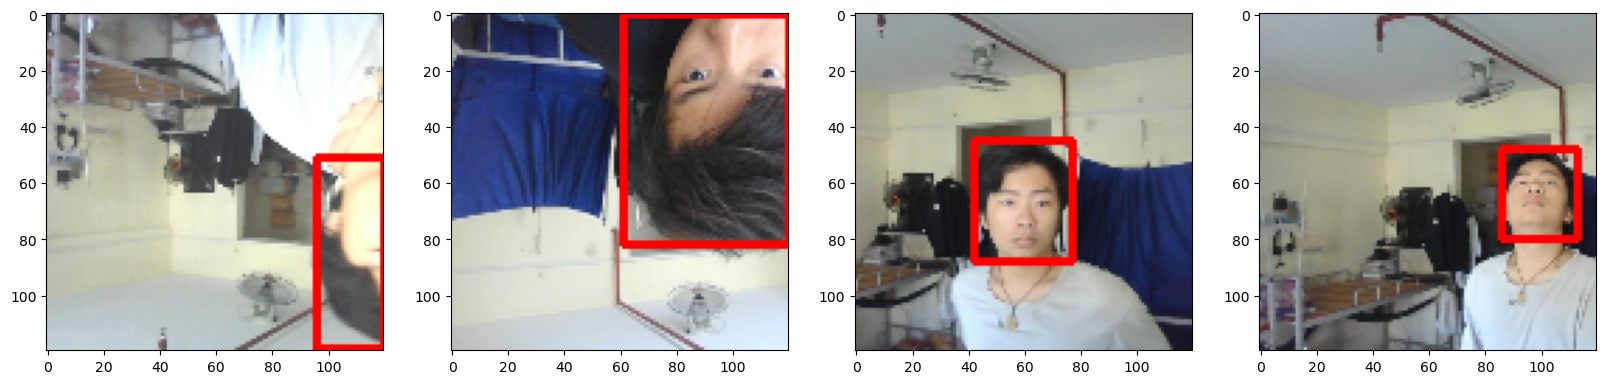

In [40]:
res = data_samples.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Build Deep Learning Model using the Functional API

In [106]:
# Import layers and base network
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50

# Online Data Agumentation
### Augmentation during training

In [99]:
def online_augmentation(image):
    # Randomly apply image augmentation techniques
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    image = tf.image.random_hue(image, max_delta=0.2)

    return image

# SSD Model

In [43]:
def build_model_SSD(): 
    input_layer = Input(shape=(120,120,3))
     # Augmentation during training
#     augmentation = online_augmentation(input_layer)
    
#     vgg = VGG16(include_top=False)(augmentation)
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class1 = BatchNormalization()(class1)
    class1 = Dropout(rate=0.5)(class1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress1 = BatchNormalization()(regress1)
    regress1 = Dropout(rate=0.5)(regress1)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

# Custom

In [111]:
# from tensorflow.keras.applications.efficientnet import EfficientNetB7 as EfficientNet
def build_model_custom(): 
    input_layer = Input(shape=(120,120,3))
    
#     efficient_net = EfficientNetB7(include_top = False)(input_layer)
    resnet = ResNet50(include_top=False)(input_layer)
    # Classification Model  
    f1 = GlobalMaxPooling2D()(resnet)
    class1 = Dense(2048, activation='relu')(f1)
    class1 = BatchNormalization()(class1)
    class1 = Dropout(rate=0.5)(class1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(resnet)
    regress1 = Dense(2048, activation='relu')(f2)
    regress1 = BatchNormalization()(regress1)
    regress1 = Dropout(rate=0.5)(regress1)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

# Test Neural Network

In [112]:
# facetracker = build_model_SSD()
facetracker = build_model_custom()

In [113]:
facetracker.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, None, None,   23587712    ['input_11[0][0]']               
                                2048)                                                             
                                                                                                  
 global_max_pooling2d_8 (Global  (None, 2048)        0           ['resnet50[0][0]']               
 MaxPooling2D)                                                                              

In [114]:
X, y = train.as_numpy_iterator().next()

In [115]:
X.shape

(8, 120, 120, 3)

In [116]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [117]:
classes, coords

(array([[0.93243015],
        [0.9290658 ],
        [0.9263358 ],
        [0.93005586],
        [0.9276914 ],
        [0.9341737 ],
        [0.93847454],
        [0.93332434]], dtype=float32),
 array([[0.48209095, 0.8351198 , 0.70602965, 0.43318453],
        [0.5028348 , 0.7944254 , 0.67824507, 0.4903868 ],
        [0.5620526 , 0.81121016, 0.6838127 , 0.48910856],
        [0.4956303 , 0.8324394 , 0.7345148 , 0.42937726],
        [0.5235793 , 0.8174946 , 0.70589066, 0.44990373],
        [0.50853807, 0.81012684, 0.6833408 , 0.47780356],
        [0.41714337, 0.8377276 , 0.70756686, 0.48261732],
        [0.4830631 , 0.84452194, 0.74055743, 0.42951772]], dtype=float32))

# Define Losses and Optimizers

In [50]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [51]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9)

In [52]:
opt = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

In [53]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [54]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [55]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [56]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.270126>

In [57]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8588015>

In [58]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.270126>

In [59]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [118]:
model = FaceTracker(facetracker)

In [119]:
model.compile(opt, classloss, regressloss)

In [121]:
logdir=r'logs\resnet'

In [122]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [64]:
# tensorboard --logdir="C:\Users\Admins\Programming\Preworking Projects\FaceRecognition\logs"
# http://localhost:6006/

path = r'C:\Users\Admins\Programming\Preworking Projects\FaceRecognition\\'

print(f"tensorboard --logdir={path}")
print('http://localhost:6006/')

tensorboard --logdir=C:\Users\Admins\Programming\Preworking Projects\FaceRecognition\\
http://localhost:6006/


In [125]:
hist = model.fit(
    train, 
    epochs=50, 
    validation_data=val, 
    callbacks=[tensorboard_callback])

Epoch 1/50


TypeError: 'NoneType' object is not callable

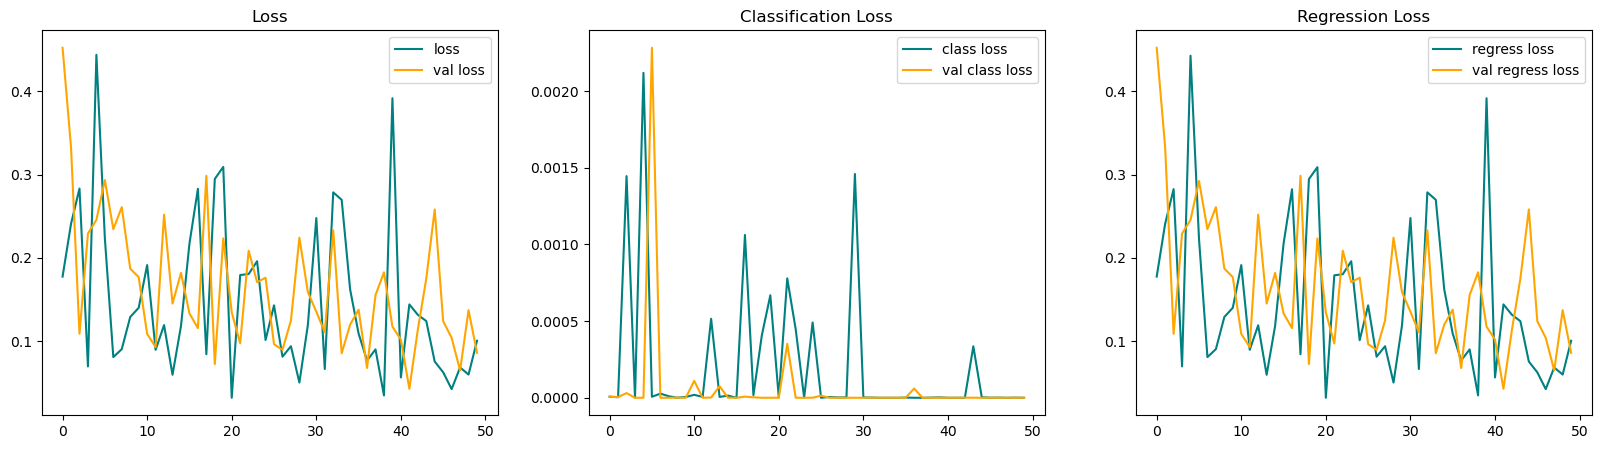

In [77]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# Make Predictions

In [78]:
test_data = test.as_numpy_iterator()

In [79]:
test_sample = test_data.next()

In [80]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


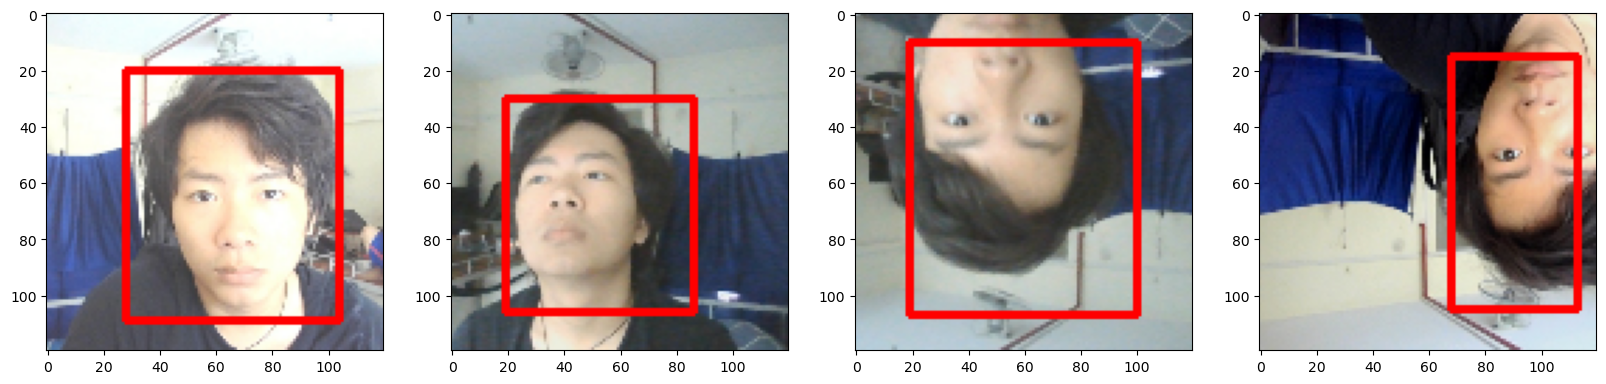

In [81]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.7:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# Save Model

In [4]:
from tensorflow.keras.models import load_model

In [128]:
facetracker.save('facetracker_custom.h5')

C:\Users\Admins\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [84]:
facetracker.save('facetracker_SSDBatchNormDropOut.h5')

In [5]:
facetracker = load_model('facetracker_custom.h5')

# Real Time Detection

In [82]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.7: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        label_text = f'face {yhat[0][0][0]}'[0:11]
        cv2.putText(frame, 
                    label_text, 
                    tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),[0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('FaceTracker', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 17ms/step


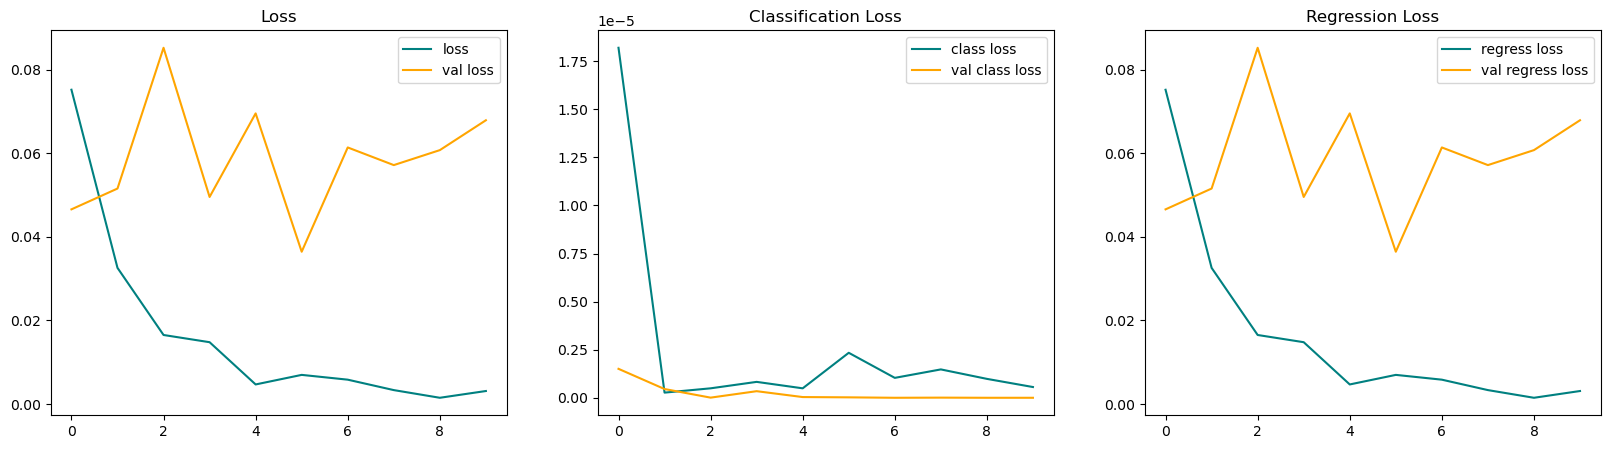
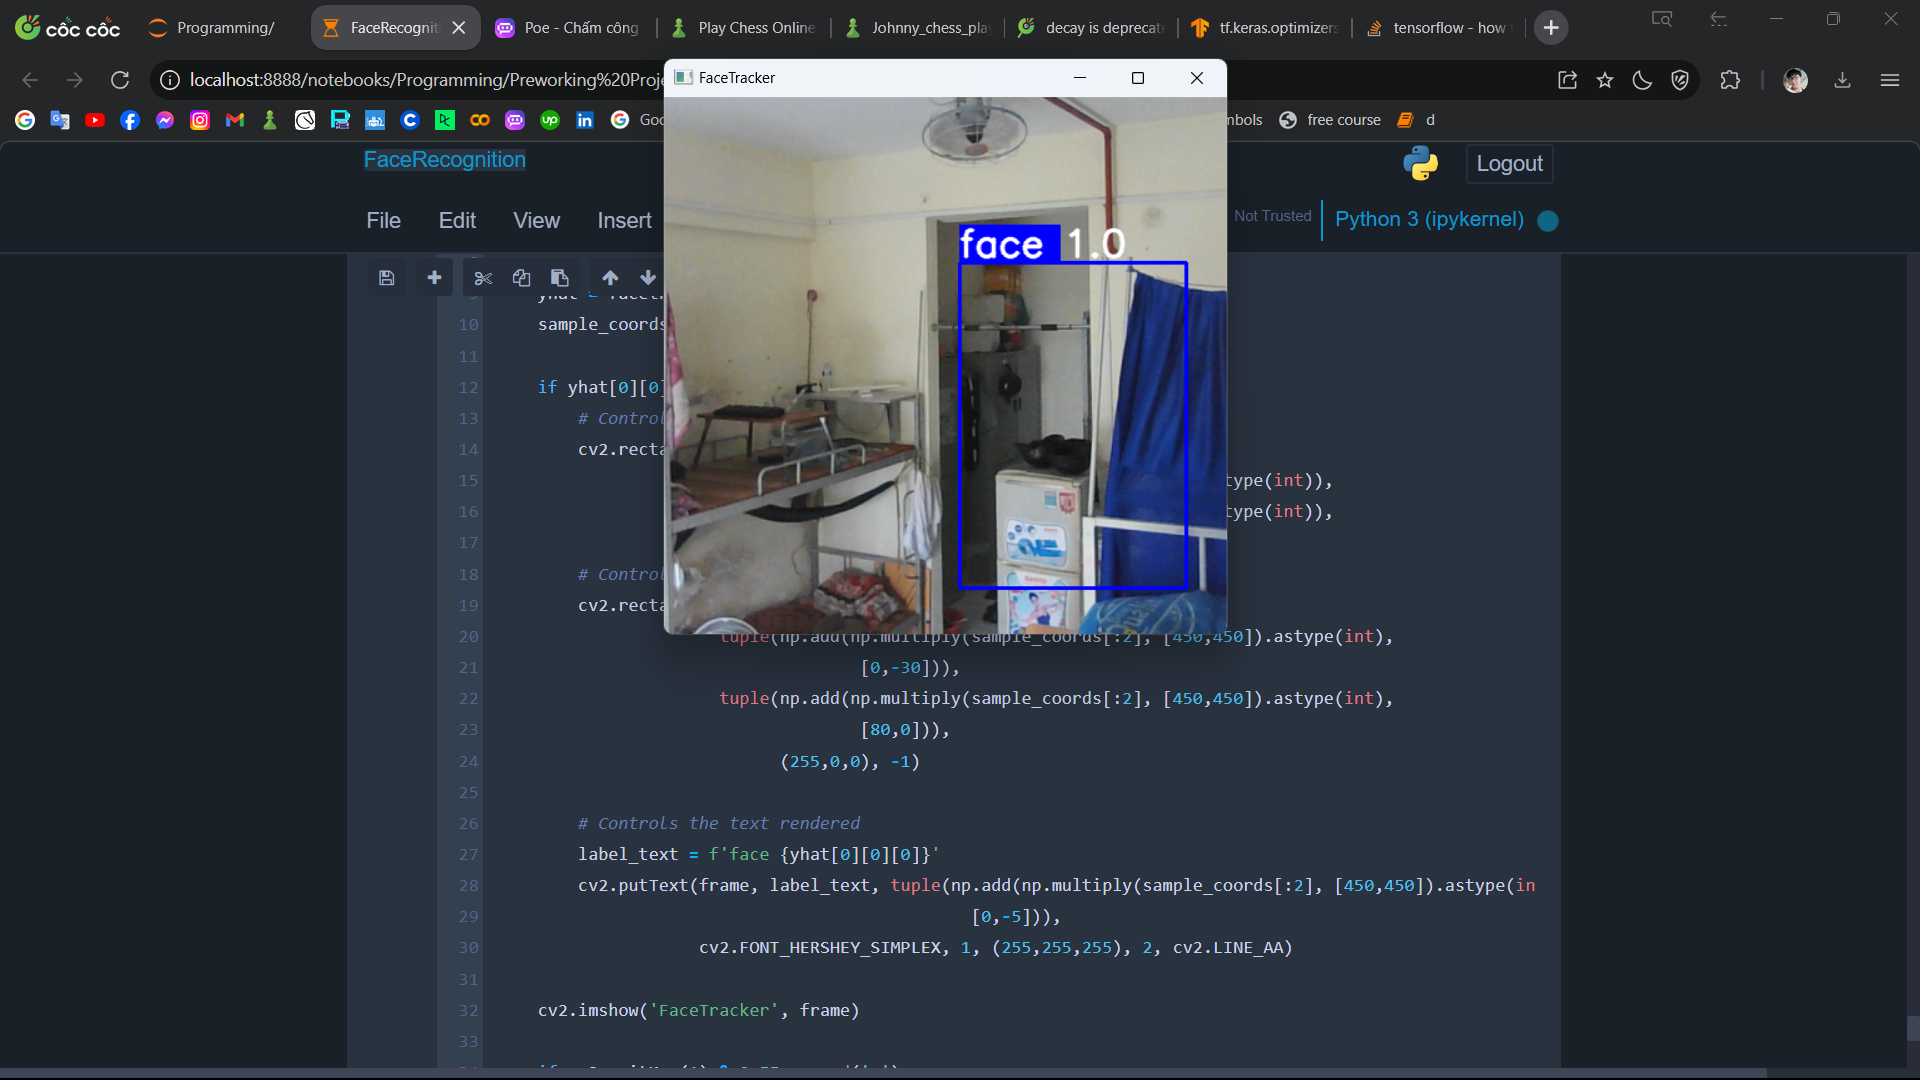